In [1]:
import numpy as np
import torch.nn as nn
from torch.nn import Parameter
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
T = 100
K = 3
D = 2
num_particles = 50

NUM_HIDDEN = 256
NUM_LATENTS = D*K
NUM_OBS = D + 1
# training parameters
NUM_SAMPLES = 1
# BATCH_SIZE = 100
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3 * 5
CUDA = False

RESTORE = False

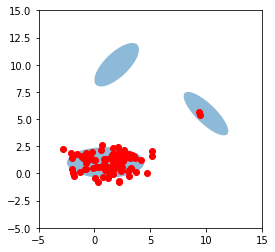

In [3]:
Xs, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
plot_samples(Xs.data.numpy(), mu_true.data.numpy(), cov_true.data.numpy())
Y = Xs

In [4]:

# cov_ks = (torch.mm((Y - Y.mean(0)).transpose(0,1), (Y - Y.mean(0))) / (T)).repeat(K, 1, 1)


## initialize variational distributions
# mu_k
mu_ks_means = Y.mean(0).float().repeat(K, 1)
mu_ks_trils = (torch.eye(D) + (torch.randn(D, D)*0.5).tril(-1)).repeat(K, 1, 1)
mu_ks_means = Parameter(mu_ks_means)
mu_ks_trils = Parameter(mu_ks_trils)


mu_ks_trils = (torch.eye(D) + (torch.randn(D, D)*0.5).tril(-1)).repeat(K, 1, 1)


optimizer =  torch.optim.Adam([mu_ks_means, mu_ks_trils],lr=LEARNING_RATE) 

In [6]:
def MLE_loss(mu_ks, LT, Y, Zs, T, D, K, num_particles=1):
    log_likelihood = 0.0
    latent_means = torch.mm(Zs, mu_ks)
    lower_trils = torch.mul(Zs.repeat(D, D, 1, 1).permute(2,3,0,1), LT.repeat(T, 1, 1, 1)).sum(1)
#     latent_stds = torch.mm(Zs, torch.exp(log_cov_ks))
    for t in range(T):
        
        log_likelihood += MultivariateNormal(latent_means[t], make_cov(lower_trils[t])).log_prob(Y[t])
    return - log_likelihood

In [9]:
LLs = torch.zeros(NUM_EPOCHS)
for epoch in range(NUM_EPOCHS):
#     latents_mean, latents_std = enc(Y, Zs_true, num_particles)
    loss = MLE_loss(mu_ks_means, mu_ks_trils, Y, Zs_true, T, D, K, num_particles)
    loss.backward()
    optimizer.step()   
#     print("epoch : %d" % epoch)
    LLs[epoch] = loss.item()

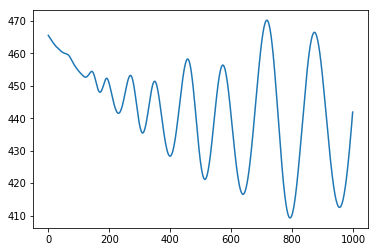

In [10]:
plt.plot(LLs.data.numpy())

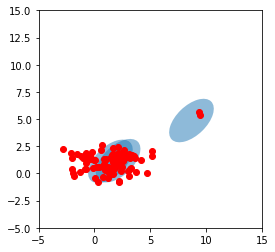

In [14]:
# mu_ks = enc.gmm_mean.data.numpy()
# gmm_cov = torch.exp(enc.gmm_log_std)
cov_ks = torch.zeros((K, D, D))
for k in range(K):
    cov_ks[k] = make_cov(mu_ks_trils[k])
cov_ks = cov_ks.data.numpy()
plot_clusters(Xs.data.numpy(), mu_ks_means.data.numpy(), cov_ks)